In [ ]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
from torchvision import datasets
import torch.optim as optim
import matplotlib.pyplot as plt
from PIL import Image as im
from sklearn.metrics import confusion_matrix
import numpy as np

In [ ]:
# Define the transformation pipeline for the CIFAR-10 dataset
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize( mean=[0.5],
                          std=[0.5],)
])

transform_validation = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize( mean=[0.5],
                          std=[0.5],)
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize( mean=[0.5],
                          std=[0.5],)
])

In [ ]:
trainset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform_train)


validset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform_validation)


testset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform_test)



100%|██████████| 26421880/26421880 [00:14<00:00, 1808274.40it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 120195.62it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2244404.80it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 4887342.01it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
trainset

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
           )

In [ ]:
def get_train_valid_loader(trainset, validset,
                           batch_size,
                           random_seed,
                           valid_size=0.1,
                           shuffle=True):

    num_train = len(trainset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(
        trainset, batch_size=batch_size, sampler=train_sampler)

    valid_loader = torch.utils.data.DataLoader(
        validset, batch_size=batch_size, sampler=valid_sampler)

    return (train_loader, valid_loader)


def get_test_loader(testset,
                    batch_size,
                    shuffle=True):

    data_loader = torch.utils.data.DataLoader(
        testset, batch_size=batch_size, shuffle=shuffle
    )

    return data_loader


# CIFAR10 dataset
trainloader, validloader = get_train_valid_loader(trainset, validset, batch_size = 128,  random_seed = 1)

testloader = get_test_loader(testset, batch_size = 128)

torch.Size([1, 28, 28])
2
torch.Size([1, 28, 28])
(28, 28, 1)


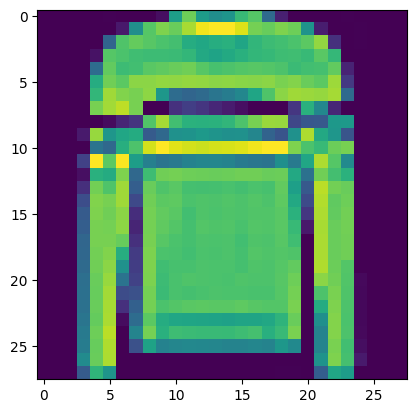

In [ ]:
id = 5
img, label = trainset[id]
print(img.shape)
print(label)
print(img.shape)
img = np.asarray(img)
img = np.transpose(img, [1, 2, 0])
print(img.shape)
# img1 = im.fromarray(img)
plt.imshow(img)

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=7, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU())
        self.path1 = nn.Sequential(
            nn.Conv2d(32, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU())
        self.path2 = nn.Sequential(
            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU())
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU())
        self.Skip_path = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU())
        self.linear1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4608, 2304),
            nn.ReLU())
        self.linear2 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(2304, 2304),
            nn.ReLU())
        self.linear3= nn.Sequential(
            nn.Linear(2304, 10))
            #nn.Softmax(dim = 10))



    def forward(self, x):
        x = self.layer1(x)
        x1 = self.path1(x)
        x2 = self.path2(x)
        x3 = torch.cat([x1, x2], 1)
        x3 = self.layer3(x3)
        x = self.Skip_path(x)
        x = x + x3
        x = x.reshape(x.size(0), -1) #flatten
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.linear3(x)
        return x

In [ ]:
model = Model()
print(model)

Model(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(7, 7), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (path1): Sequential(
    (0): Conv2d(32, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (path2): Sequential(
    (0): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (Skip_path): Sequential(
    (0): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (

In [ ]:
num_epochs = 15
learning_rate = 0.001

if torch.cuda.is_available():
    model.to('cuda')
else:
    model.to('cpu')


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
Train_Accuracy = []
Test_Accuracy = []
total_step = len(trainloader)
path = r"/content/Saved_models"
max_acc = 0
iter = 0
for epoch in range(num_epochs):
    running_loss = 0.0
    running_correct = 0
    total = 0
    print("-"*50)
    for i, (images, labels) in enumerate(trainloader):
        # Move tensors to the configured device

        if torch.cuda.is_available():
          images = images.to('cuda')
          labels = labels.to('cuda')

        # Forward pass
        outputs = model(images)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        running_correct += (pred == labels).sum().item()
        loss = criterion(outputs, labels)
        #running_loss = running_loss + loss.data
        #print("[E: %d] loss: %f, avg_loss: %f" % (epoch, loss.data, running_loss/cnt))

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Train Accuracy is:{:.4f}%'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item(), 100*running_correct/total))

    # Validation
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in validloader:
            if torch.cuda.is_available():
              images = images.to('cuda')
              labels = labels.to('cuda')
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs
        val_acc = 100 * correct / total
        print('Accuracy of the network on the {} validation images: {} %'.format(5000, val_acc))
        Train_Accuracy.append(running_correct/len(trainset))
        Test_Accuracy.append(val_acc)
        if (val_acc>max_acc):
          max_acc = val_acc
          iter = epoch
          torch.save(model.state_dict(), os.path.join(path, 'epoch-{}_Val_acc-{}.pt'.format(epoch, val_acc)))

--------------------------------------------------
Epoch [1/15], Step [422/422], Loss: 0.4140, Train Accuracy is:78.9537%
Accuracy of the network on the 5000 validation images: 82.76666666666667 %
--------------------------------------------------
Epoch [2/15], Step [422/422], Loss: 0.5605, Train Accuracy is:84.9500%
Accuracy of the network on the 5000 validation images: 85.5 %
--------------------------------------------------
Epoch [3/15], Step [422/422], Loss: 0.3947, Train Accuracy is:86.4241%
Accuracy of the network on the 5000 validation images: 85.73333333333333 %
--------------------------------------------------
Epoch [4/15], Step [422/422], Loss: 0.3576, Train Accuracy is:87.4630%
Accuracy of the network on the 5000 validation images: 86.88333333333334 %
--------------------------------------------------
Epoch [5/15], Step [422/422], Loss: 0.2690, Train Accuracy is:88.1278%
Accuracy of the network on the 5000 validation images: 87.55 %
----------------------------------------

In [ ]:
Train_array = np.array(Train_Accuracy)
Test_array = np.array(Test_Accuracy)
Test_array

array([82.76666667, 85.5       , 85.73333333, 86.88333333, 87.55      ,
       87.18333333, 88.15      , 88.81666667, 88.61666667, 89.6       ,
       89.18333333, 89.41666667, 89.2       , 89.51666667, 89.68333333])

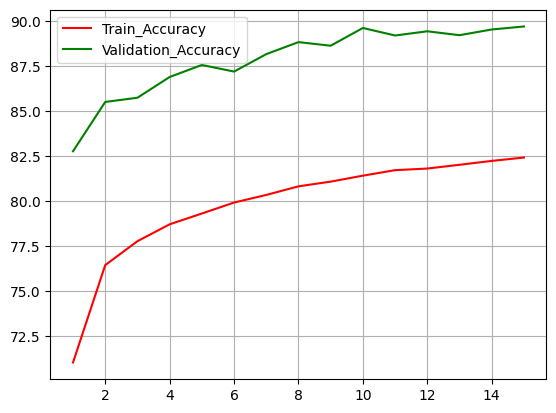

In [ ]:
A = np.arange(1, num_epochs+1)
plt.plot(A, Train_array*100, color='r', label='Train_Accuracy')
plt.plot(A, Test_array, color='g', label='Validation_Accuracy')
plt.grid()
plt.legend()

In [ ]:
with torch.no_grad():
    correct = 0
    total = 0

    for images, labels in testloader:
        if torch.cuda.is_available():
              images = images.to('cuda')
              labels = labels.to('cuda')
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs

    print('Accuracy of the network on the {} test images: {} %'.format(10000, 100 * correct / total))

Accuracy of the network on the 10000 test images: 90.8 %


Class-wise F1 score:
[0.86826923 0.9884131  0.8548233  0.91826438 0.84477612 0.96929376
 0.73168103 0.95377129 0.98439859 0.95943916]


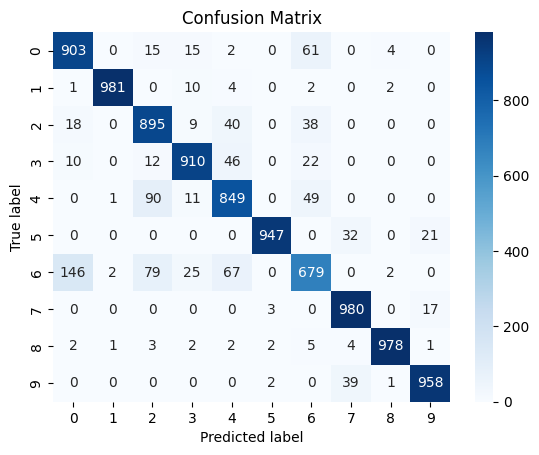

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns


model.eval()

# Get the predictions and true labels for the test set
preds = []
true_labels = []
with torch.no_grad():
    for data, labels in testloader:
        data = data.to('cuda')
        labels = labels.to('cuda')
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        preds.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Calculate the confusion matrix and class-wise F1 score
cm = confusion_matrix(true_labels, preds)
f1 = f1_score(true_labels, preds, average=None)

print("Class-wise F1 score:")
print(f1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()
